In [48]:
import numpy as np
np.random.seed(42)
import pandas as pd 
import matplotlib.pyplot as plt 
from tests import *
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
%matplotlib inline

## Dataset :

In [12]:
data = pd.read_csv("DATA/ParisHousing.csv")
print(data.shape)

(10000, 17)


In [13]:
y = data['price']
print(y[:5])

0    7559081.5
1    8085989.5
2    5574642.1
3    3232561.2
4    7055052.0
Name: price, dtype: float64


In [14]:
X = data.drop('price', axis = 1) 
print(X.head())

   squareMeters  numberOfRooms  hasYard  hasPool  floors  cityCode  \
0         75523              3        0        1      63      9373   
1         80771             39        1        1      98     39381   
2         55712             58        0        1      19     34457   
3         32316             47        0        0       6     27939   
4         70429             19        1        1      90     38045   

   cityPartRange  numPrevOwners  made  isNewBuilt  hasStormProtector  \
0              3              8  2005           0                  1   
1              8              6  2015           1                  0   
2              6              8  2021           0                  0   
3             10              4  2012           0                  1   
4              3              7  1990           1                  0   

   basement  attic  garage  hasStorageRoom  hasGuestRoom  
0      4313   9005     956               0             7  
1      3653   2436     128  

In [15]:
print(y.shape)
print(X.shape)
print("number of training examples, m =", len(X))


(10000,)
(10000, 16)
number of training examples, m = 10000


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 16)
(2000, 16)
(8000,)
(2000,)


## Building a decision Tree model

In [17]:
# computes the variance (measure of impurity) at a node.
def compute_variance(y):
    return np.var(y) if len(y) > 0 else 0

In [18]:
print("variance at root node :", compute_variance(y_train)) 

variance at root node : 8154429121291.906


In [19]:
def split_dataset(X, node_indices, feature, threshold):
    """
    Splits the data at the given node into left and right branches
    based on the given feature and threshold.
    
    Parameters:
    - X: ndarray, shape (n_samples, n_features)
    - node_indices: list of indices of samples at the current node
    - feature: int, feature index to split on
    - threshold: float, threshold value for the split

    Returns:
    - left_indices: list of sample indices for the left child
    - right_indices: list of sample indices for the right child
    """
    left_indices = []
    right_indices = []
    for i in node_indices:
        if X[i,feature] <= threshold:
            left_indices.append(i)
        else:
            right_indices.append(i)
            
    return left_indices, right_indices

In [20]:
split_dataset_test(split_dataset)

 🌳 All tests passed for split_dataset.


In [21]:
def compute_variance_reduction(X, y, node_indices, feature, threshold):
    """
    Compute the variance reduction (information gain) from splitting the node
    on a given feature and threshold.
    
    Parameters:
    - X: feature matrix (ndarray)
    - y: target vector (ndarray)
    - node_indices: list of indices of samples at the current node
    - feature: index of the feature to split on
    - threshold: threshold value for the split

    Returns:
    - variance_reduction: float
    """
    total_samples = len(node_indices)

    # Split the data
    left_indices, right_indices = split_dataset(X, node_indices, feature, threshold)

    # If no split is made (one side is empty), return 0 gain
    if len(left_indices) == 0 or len(right_indices) == 0:
        return 0

    y_node = y[node_indices]
    y_left = y[left_indices]
    y_right = y[right_indices]

    w_left = len(left_indices) / total_samples
    w_right = len(right_indices) / total_samples

    reduction = compute_variance(y_node) - (w_left * compute_variance(y_left) + w_right * compute_variance(y_right))
    return reduction

In [22]:
#features in our dataset
for i,col in enumerate(X_train.columns):
    print(f"{i} : {col}")

0 : squareMeters
1 : numberOfRooms
2 : hasYard
3 : hasPool
4 : floors
5 : cityCode
6 : cityPartRange
7 : numPrevOwners
8 : made
9 : isNewBuilt
10 : hasStormProtector
11 : basement
12 : attic
13 : garage
14 : hasStorageRoom
15 : hasGuestRoom


In [23]:
root_indices = list(range(X_train.shape[0]))
info_gain0 = compute_variance_reduction(X_train.values, y_train.values, root_indices, feature= 0, threshold = 45000)
print(" Information Gain from splitting the root on squareMeters : ", info_gain0)
info_gain1 = compute_variance_reduction(X_train.values, y_train.values, root_indices, feature= 3, threshold = 0)
print(" Information Gain from splitting the root on having or not a pool  : ", info_gain1)
info_gain1 = compute_variance_reduction(X_train.values, y_train.values, root_indices, feature= 9, threshold = 0)
print(" Information Gain from splitting the root on being or not a NewBuilt  : ", info_gain1)
#Unit tests
compute_variance_reduction_test(compute_variance_reduction)

 Information Gain from splitting the root on squareMeters :  6023601010534.186
 Information Gain from splitting the root on having or not a pool  :  2396584908.6015625
 Information Gain from splitting the root on being or not a NewBuilt  :  748576815.0390625
 🌳 All tests passed for compute_variance_reduction.


In [24]:
def get_thresholds(X,node_indices, feature, max_thresholds = 100):  
    """
    Returns:
    thresholds: possible thresholds (midpoints) for a given feature at the current node.
    """
    thresholds =[]
    X_node = X[node_indices]
    L = len(node_indices)
    if L <= 1:
        return []

    data_feature = np.sort( np.unique( X_node[:,feature]))
    midpoints = [(data_feature[i]+data_feature[i+1])/2 for i in range(len(data_feature)-1)]
    
    if len(midpoints) > max_thresholds:
        indices = np.linspace(0, len(midpoints) - 1, max_thresholds, dtype=int)
        midpoints = [midpoints[i] for i in indices]
    return midpoints


In [25]:
thresholds = get_thresholds(X_train.values, root_indices, feature = 0, max_thresholds = 20)
print("possible thresholds for the feature SquareMeters :",thresholds[:10])
#UNIT tests 
get_thresholds_test(get_thresholds)

possible thresholds for the feature SquareMeters : [100.0, 5212.0, 10551.0, 15942.0, 20993.0, 26409.0, 31701.0, 36865.0, 41861.5, 47180.5]
 🌳 All tests passed for get_thresholds.


In [26]:
def get_best_split(X, y, node_indices, available_features):
    """
    Returns the optimal feature and threshold value
    to split the node data 
    
    Args:
        X (ndarray):            Data matrix of shape(n_samples, n_features)
        y (array like):         list or ndarray with n_samples containing the target variable
        node_indices (ndarray): List containing the active indices. I.e, the samples being considered in this step.

    Returns:
        best_feature (int):     The index of the best feature to split
        best_threshold (float):  The best threshold to choose fo best_feature
    """    
    #num_features = X.shape[1]
    max_VR = 0.
    best_feature = -1
    best_threshold = 0.
    for idx_feature in available_features:
        thresholds = get_thresholds(X, node_indices, idx_feature)
        #print(f"Feature {idx_feature}: trying {len(thresholds)} thresholds")
        for threshold in thresholds :
            current_VR = compute_variance_reduction(X, y, node_indices, idx_feature, threshold)
            if current_VR > max_VR:
                max_VR = current_VR
                best_threshold = threshold
                best_feature = idx_feature
    return best_feature, best_threshold


In [27]:
available_features = list(range(X_train.shape[1]))
best_root_feature,best_root_threshold = get_best_split(X_train.values, y_train.values, root_indices, available_features)
feature_name = X_train.columns[best_root_feature]
print(f"The best feature to split on from the root is feature {best_root_feature} ({feature_name}), with threshold {best_root_threshold}")

The best feature to split on from the root is feature 0 (squareMeters), with threshold 49138.0


In [28]:
def build_tree(X, y, node_indices, branch_name, max_depth, current_depth = 0, available_features=None):
    """
    Build a tree using the recursive algorithm that split the dataset into 2 subgroups at each node.
    
    Args:
        X (ndarray):            Data matrix of shape(n_samples, n_features)
        y (array like):         list or ndarray with n_samples containing the target variable
        node_indices (ndarray): List containing the active indices. I.e, the samples being considered in this step.
        branch_name (string):   Name of the branch. ['Root', 'Left', 'Right']
        max_depth (int):        Max depth of the resulting tree. 
        current_depth (int):    Current depth. Parameter used during recursive call.
   
    """
    y_node = y[node_indices]
    if available_features is None:
        available_features = list(range(X.shape[1]))
    #checking if we have a pure class 
    pure = len(np.unique(y_node)) == 1
    if current_depth == max_depth or len(node_indices) == 0 or pure :
        return {"is_leaf" : True, "prediction" : np.mean(y_node)}
    else:
        #get the best feature and threshold to split on 
        best_feature, best_threshold = get_best_split(X, y, node_indices, available_features)
    
        #split the dataset at the best feature and best threshold 
        left_indices, right_indices = split_dataset(X, node_indices, best_feature, best_threshold)

        if len(left_indices) == 0 or len(right_indices) == 0:
            return {"is_leaf": True, "prediction": np.mean(y_node)}

        # continue splitting the left and the right child. Increment current depth
        new_features = [f for f in available_features if f != best_feature]
        left_tree = build_tree(X, y, left_indices, "left", max_depth, current_depth + 1, available_features=new_features)
        right_tree = build_tree(X, y, right_indices, "right", max_depth, current_depth + 1, available_features=new_features)
        return {
                "is_leaf": False,
                "feature": best_feature,
                "threshold": best_threshold,
                "left": left_tree,
                "right": right_tree
                }
    

In [29]:
def print_tree(tree, feature_names, spacing=""):
    if tree["is_leaf"]:
        print(spacing + f"🌿 Leaf -> Prediction: {round(tree['prediction'], 2)}")
        return

    feature_name = feature_names[tree["feature"]]
    threshold = tree["threshold"]
    print(spacing + f" [Split] {feature_name} <= {threshold}")

    print(spacing + "├── Left:")
    print_tree(tree["left"], feature_names, spacing + "│   ")

    print(spacing + "└── Right:")
    print_tree(tree["right"], feature_names, spacing + "    ")


In [30]:
train_indices = list(range(len(X_train)))
tree = build_tree(X_train.values, y_train.values, train_indices, "Root", max_depth=5)
print_tree(tree, X_train.columns)

 [Split] squareMeters <= 49138.0
├── Left:
│    [Split] cityCode <= 98741.5
│   ├── Left:
│   │    [Split] floors <= 38.5
│   │   ├── Left:
│   │   │    [Split] made <= 2015.5
│   │   │   ├── Left:
│   │   │   │    [Split] numberOfRooms <= 17.5
│   │   │   │   ├── Left:
│   │   │   │   │   🌿 Leaf -> Prediction: 2255772.98
│   │   │   │   └── Right:
│   │   │   │       🌿 Leaf -> Prediction: 2485796.91
│   │   │   └── Right:
│   │   │        [Split] garage <= 704.0
│   │   │       ├── Left:
│   │   │       │   🌿 Leaf -> Prediction: 2405554.4
│   │   │       └── Right:
│   │   │           🌿 Leaf -> Prediction: 1847604.25
│   │   └── Right:
│   │        [Split] attic <= 9474.0
│   │       ├── Left:
│   │       │    [Split] basement <= 104.5
│   │       │   ├── Left:
│   │       │   │   🌿 Leaf -> Prediction: 3062195.75
│   │       │   └── Right:
│   │       │       🌿 Leaf -> Prediction: 2501532.12
│   │       └── Right:
│   │            [Split] numberOfRooms <= 32.5
│   │           ├── Left

## prediction : 

In [31]:
def predict(tree,x):
    if tree["is_leaf"]:
        return tree['prediction']
    else:
        feature = tree["feature"]
        threshold = tree["threshold"]
        if x[feature] < threshold :
            return predict(tree["left"],x)
        else:
            return predict(tree["right"],x)

In [32]:
y_test_np = y_test.values
y_preds = np.array([predict(tree, x) for x in X_test.values])
print(f"Predicted price: {y_preds[0]}, real_price: {y_test_np[0]}")
print(f"Predicted price: {y_preds[1]}, real_price: {y_test_np[1]}")
print(f"Predicted price: {y_preds[2]}, real_price: {y_test_np[2]}")
print(f"Predicted price: {y_preds[3]}, real_price: {y_test_np[3]}")

Predicted price: 7457414.057295521, real_price: 7964369.6
Predicted price: 2501532.120544337, real_price: 3713548.9
Predicted price: 7457414.057295521, real_price: 8553019.2
Predicted price: 7272585.48037518, real_price: 6428666.2


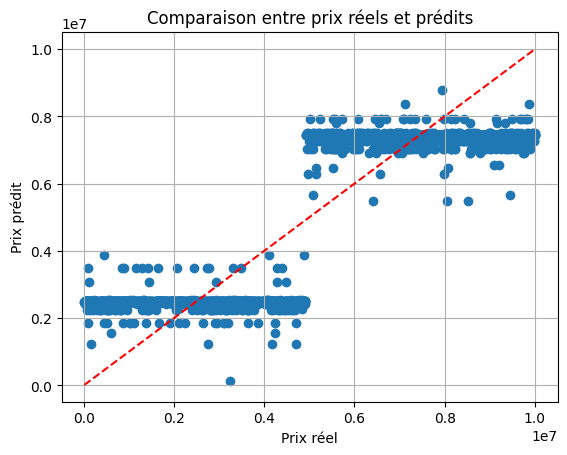

In [33]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_preds)
plt.xlabel("Prix réel")
plt.ylabel("Prix prédit")
plt.title("Comparaison entre prix réels et prédits")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")
plt.grid(True)
plt.show()

## evaluation 

In [34]:
print("MSE :", mean_squared_error(y_test, y_preds))
print("R² :", r2_score(y_test, y_preds))

MSE : 2198691534897.1736
R² : 0.7489721685434383


Text(0.5, 1.0, 'Distribution des erreurs')

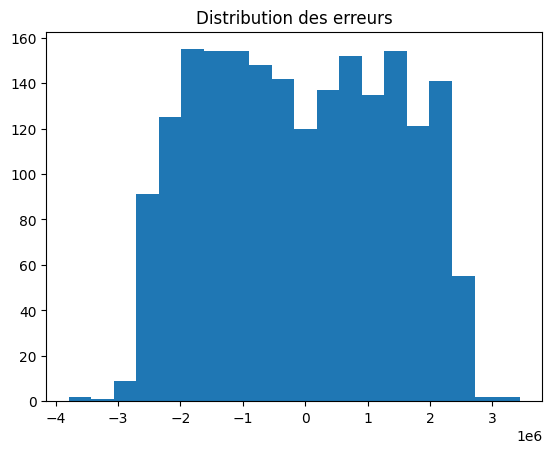

In [35]:
errors = y_preds - y_test
plt.hist(errors, bins=20)
plt.title("Distribution des erreurs")

## 🌲 Random Forest from scratch

In [36]:
def random_forest_train(X, y, n_trees, max_depth):
    """
    Trains a random forest composed of multiple decision trees.

    Parameters:
    - X : ndarray (m, F) → feature matrix
    - y : ndarray (m,) → target vector
    - n_trees : int, number of trees to train
    - max_depth : int, maximum depth for each tree

    Returns:
    - forest : list of dicts with each tree and its selected feature indices
    """
    m, F = X.shape
    forest = []

    for b in range(n_trees):
        # 1. Bootstrap sampling (sampling with replacement)
        indices = np.random.choice(m, size=m, replace=True)
        X_new = X[indices]
        y_new = y[indices]

        # 2. Random feature selection (sqrt(F) features)
        f = F
        selected_features = np.random.choice(F, size=f, replace=False)
        X_selected = X_new[:, selected_features]

        # 3. Train a decision tree on the sampled data and selected features
        train_indices = list(range(len(X_selected)))
        tree = build_tree(
            X_selected, y_new,
            train_indices,
            branch_name="Root",
            max_depth=max_depth,
            available_features=list(range(f))  # important: re-indexed features
        )

        # 4. Store the trained tree and its feature indices
        forest.append({
            "tree": tree,
            "features": selected_features
        })

        print(f"tree number {b} is trained")

    return forest


In [37]:
def random_forest_predict(forest, x):
    """
    Predicts the target value for a single sample x using the trained random forest.

    Parameters:
    - forest : list of dicts, each containing a tree and the feature indices it used
    - x : ndarray (F,) → one sample with all features

    Returns:
    - prediction : float, aggregated prediction (mean of all tree predictions)
    """
    predictions = []

    for tree_dict in forest:
        tree = tree_dict["tree"]
        features = tree_dict["features"]
        
        # Select only the features used by this tree
        x = np.asarray(x).flatten() 
        x_selected = x[features]

        
        # Predict with this tree
        prediction = predict(tree, x_selected)
        predictions.append(prediction)

    # Aggregate predictions (you can use np.median instead if you want to test robustness)
    return np.mean(predictions)


### Training and prediction (with the best parameters after Hyperparameter Tuning below)

In [40]:
# Note: After testing different values of f (sqrt(F), F/2, F),
# we found that using all features (f = F) consistently gave the best performance.
# This configuration (n_trees = 20, max_depth = 5, f = F) yielded the highest R² 
np.random.seed(42)
forest = random_forest_train(X_train.values, y_train.values, n_trees=20, max_depth=5)
y_preds = np.array([random_forest_predict(forest, x) for x in X_test.values])


tree number 0 is trained
tree number 1 is trained
tree number 2 is trained
tree number 3 is trained
tree number 4 is trained
tree number 5 is trained
tree number 6 is trained
tree number 7 is trained
tree number 8 is trained
tree number 9 is trained
tree number 10 is trained
tree number 11 is trained
tree number 12 is trained
tree number 13 is trained
tree number 14 is trained
tree number 15 is trained
tree number 16 is trained
tree number 17 is trained
tree number 18 is trained
tree number 19 is trained


### evaluation 

In [41]:
r2 = r2_score(y_test.values, y_preds)
mse = mean_squared_error(y_test.values, y_preds)
print(f" Final Results — R² = {r2:.4f}, MSE = {mse:.2e}")

 Final Results — R² = 0.7613, MSE = 2.09e+12


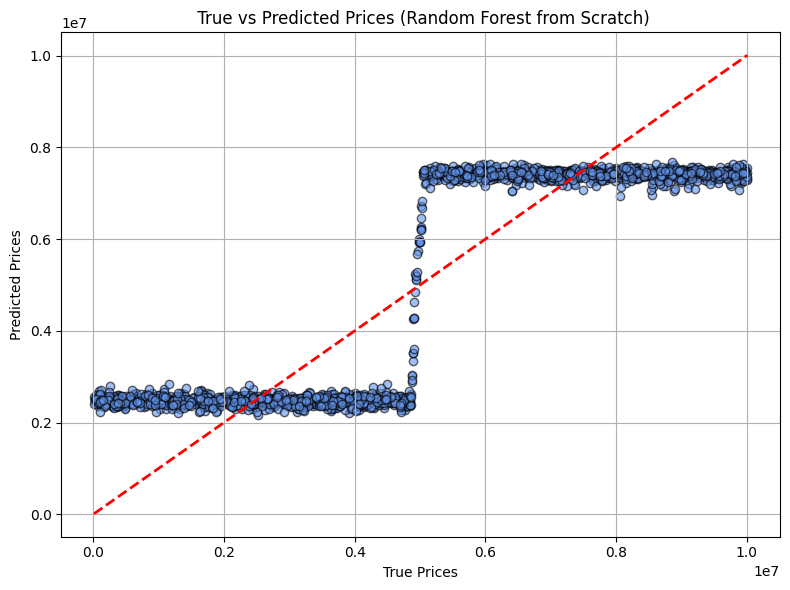

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_preds, alpha=0.6, edgecolors='k', color='cornflowerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("True Prices")
plt.ylabel("Predicted Prices")
plt.title(" True vs Predicted Prices (Random Forest from Scratch)")
plt.grid(True)
plt.tight_layout()
plt.show()


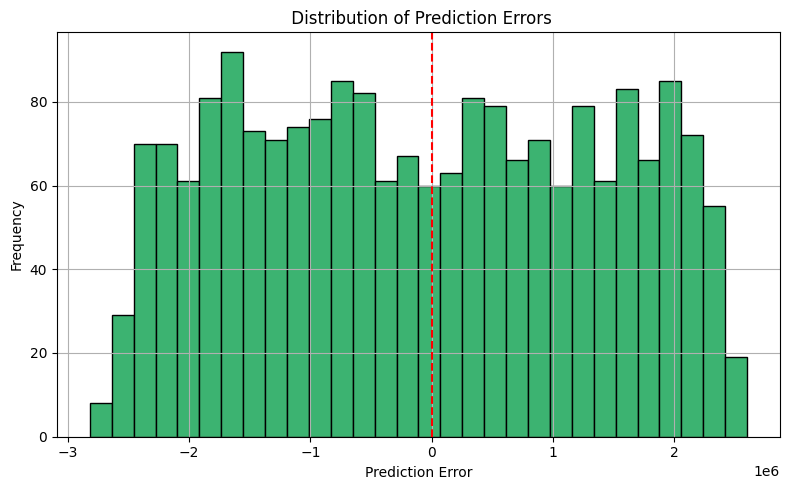

In [43]:
errors = y_preds - y_test.values

plt.figure(figsize=(8, 5))
plt.hist(errors, bins=30, color='mediumseagreen', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title(" Distribution of Prediction Errors")
plt.grid(True)
plt.tight_layout()
plt.show()

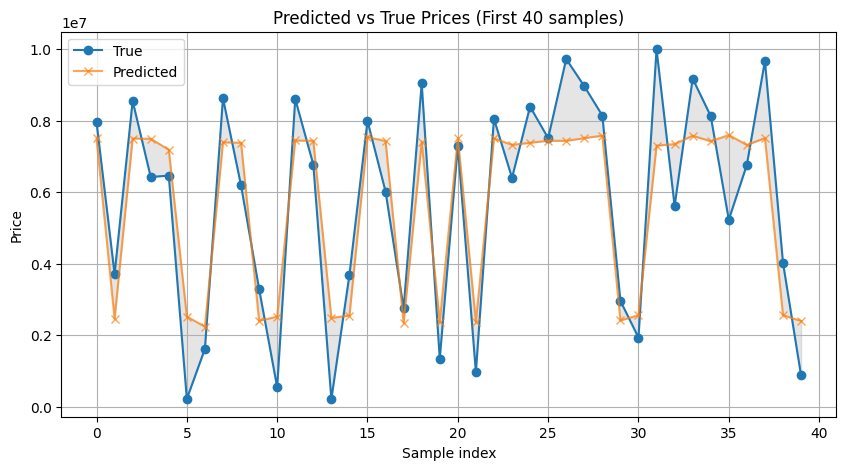

In [44]:
plt.figure(figsize=(10, 5))
plt.plot(y_test_np[:40], label='True', marker='o')
plt.plot(y_preds[:40], label='Predicted', marker='x', alpha=0.7)
plt.legend()
plt.title('Predicted vs True Prices (First 40 samples)')
plt.ylabel('Price')
plt.xlabel('Sample index')
plt.fill_between(range(40), y_test_np[:40], y_preds[:40], color='gray', alpha=0.2, label='Error')
plt.grid(True)
plt.show()

In [45]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=20, max_depth=10, random_state=42)
model.fit(X_train, y_train)
y_pred_sklearn = model.predict(X_test)

print(" Sklearn R²:", r2_score(y_test, y_pred_sklearn))
print(" Sklearn MSE:", mean_squared_error(y_test, y_pred_sklearn))


 Sklearn R²: 0.99999803526456
 Sklearn MSE: 17208638.40113165


### Hyperparameter Tuning 

In [46]:
n_trees_list = [5, 10, 15, 20, 25, 30]
max_depth_list = [5] # tested all [5, 10, 20, 50] the best performance is in max_depth = 5

best_r2 = -float('inf')
best_config = {}

for n_trees in n_trees_list:
    for max_depth in max_depth_list:
        print(f"\nTraining forest with n_trees = {n_trees}, max_depth = {max_depth}")
        
        forest = random_forest_train(X_train.values, y_train.values, n_trees=n_trees, max_depth=max_depth)
        y_preds = np.array([random_forest_predict(forest, x) for x in X_test.values])
        
        r2 = r2_score(y_test.values, y_preds)
        mse = mean_squared_error(y_test.values, y_preds)

        print(f"R² = {r2:.4f}, MSE = {mse:.2e}")
        
        if r2 > best_r2:
            best_r2 = r2
            best_config = {"n_trees": n_trees, "max_depth": max_depth, "r2": r2, "mse": mse}



Training forest with n_trees = 5, max_depth = 5
tree number 0 is trained
tree number 1 is trained
tree number 2 is trained
tree number 3 is trained
tree number 4 is trained
R² = 0.7566, MSE = 2.13e+12

Training forest with n_trees = 10, max_depth = 5
tree number 0 is trained
tree number 1 is trained
tree number 2 is trained
tree number 3 is trained
tree number 4 is trained
tree number 5 is trained
tree number 6 is trained
tree number 7 is trained
tree number 8 is trained
tree number 9 is trained
R² = 0.7584, MSE = 2.12e+12

Training forest with n_trees = 15, max_depth = 5
tree number 0 is trained
tree number 1 is trained
tree number 2 is trained
tree number 3 is trained
tree number 4 is trained
tree number 5 is trained
tree number 6 is trained
tree number 7 is trained
tree number 8 is trained
tree number 9 is trained
tree number 10 is trained
tree number 11 is trained
tree number 12 is trained
tree number 13 is trained
tree number 14 is trained
R² = 0.7597, MSE = 2.10e+12

Training fo

In [47]:
print("\n Best configuration found:")
print(f"n_trees = {best_config['n_trees']}, max_depth = {best_config['max_depth']}")
print(f"Best R² = {best_config['r2']:.4f}, Best MSE = {best_config['mse']:.2e}")


 Best configuration found:
n_trees = 20, max_depth = 5
Best R² = 0.7604, Best MSE = 2.10e+12
